## Imbalanced Data

Most classification algorithms will only perform optimally when the number of samples in each
class is roughly the same. Highly skewed datasets where the minority class is outnumbered by
one or more classes commonly occur in fraud detection, medical diagnosis and computational
biology. One way of addressing this issue is by re-sampling the dataset to offset the imbalance
and arrive at a more robust and accurate decision boundary. Re-sampling techniques can be
broadly divided into four categories: undersampling the majority class, over-sampling the minority class, combining over and under sampling, and creating ensemble of balanced datasets [1]

### Undersampling Strategies

<img src="figures/undersampling.png">

Undersampling methods remove data from the majority class of the original dataset as shown in the figure above. Random Under Sampler simply removes data points from the majority class uniformly at random. Cluster Centroids is a method that replaces cluster of samples by the cluster centroid of a K-means algorithm, where the number of clusters is set by the level of undersampling. Tomek links remove unwanted overlap between classes where Tomek links are removed until all minimally distanced nearest neighbor pairs are of the same class. A Tomek link is defined as follows: given an instance pair $(x_i, x_j)$, where $x_i \in S_{min}$, $x_j \in S_{maj}$ and $d(x_i, x_j)$ is the distance between $x_i$ and $x_j$, then the $(x_i, x_j)$ pair is called a Tomek link if there's no instance $x_k$ such that $d(x_i, x_k) < d(x_i, x_j)$ or $d(x_j, x_k) < d(x_i, x_j)$. In this way, if two instances form a Tomek link then either one of these instances is noise or both are near a border. Therefore one can use Tomek links to clean up overlap between classes. By removing overlapping examples, one can establish well-defined clusters in the training set and lead to improved classification performance. The One Sided Selection (OSS) method selects a representative subset of the majority class $E$ and combines it with the set of all minority examples $S_{min}$ to form $N = \{E \cup S_{min}\}$. The reduced set $N$ is further processed to remove all majority class Tomek links.

Let's experiment with Tomek links undersampling using the imbalanced-learn library [2].

In [4]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from imblearn.under_sampling import TomekLinks

In [5]:
rng = np.random.RandomState(0)
n_samples_1 = 500
n_samples_2 = 50
X_syn = np.r_[1.5 * rng.randn(n_samples_1, 2), 0.5 * rng.randn(n_samples_2, 2) + [2, 2]]
y_syn = np.array([0] * (n_samples_1) + [1] * (n_samples_2))
X_syn, y_syn = shuffle(X_syn, y_syn)
X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn)

In [6]:
# remove Tomek links
tl = TomekLinks(return_indices=True)
X_resampled, y_resampled, idx_resampled = tl.fit_sample(X_syn, y_syn)

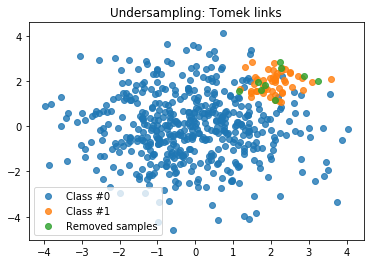

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

idx_samples_removed = np.setdiff1d(np.arange(X_syn.shape[0]),
                                   idx_resampled)
idx_class_0 = y_resampled == 0
plt.scatter(X_resampled[idx_class_0, 0], X_resampled[idx_class_0, 1], alpha=.8, label='Class #0')
plt.scatter(X_resampled[~idx_class_0, 0], X_resampled[~idx_class_0, 1], alpha=.8, label='Class #1')
plt.scatter(X_syn[idx_samples_removed, 0], X_syn[idx_samples_removed, 1], alpha=.8, label='Removed samples')
plt.title('Undersampling: Tomek links')
plt.legend()
plt.show()

Thus, we can see that removing unwanted class overlap can increase robustness of our decision boundary and improve classification accuracy.

### Oversampling Strategies

<img src="figures/oversampling.png">

Oversampling methods append data to the minority class of the original dataset as shown in the figure above. Random Over Sampler simply adds data points to the minority class uniformly at random. Synthetic Minority Oversampling Technique (SMOTE) generates synthetic examples by finding K nearest neighbors in the feature space and generating a new data point along the line segments joining any of the K minority class nearest neighbors. Synthetic samples are generated in the following way: take the difference between the feature vector (sample) under consideration and its nearest neighbor, multiply this difference by a random number between 0 and 1 and add it to the feature vector under consideration thus augmenting the dataset with a new data point. Adaptive Synthetic Sampling (ADASYN) uses a weighted distribution for different minority class examples according to their level of difficulty in learning, where more synthetic data is generated for minority class examples that are harder to learn. As a result, the ADASYN approach improves learning of imbalanced dataset in two ways: reducing the bias introduced by class imbalance and adaptively shifting the classification decision boundary toward the difficult examples.

Let's experiment with SMOTE oversampling using the imbalanced-learn library [2].

In [10]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

In [11]:
def plot_resampling(ax, X, y, title):
    c0 = ax.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5)
    c1 = ax.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5)
    ax.set_title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([-6, 8])
    ax.set_ylim([-6, 6])

    return c0, c1

In [12]:
# generate the dataset
X, y = make_classification(n_classes=2, class_sep=2, weights=[0.3, 0.7],
                           n_informative=3, n_redundant=1, flip_y=0,
                           n_features=20, n_clusters_per_class=1,
                           n_samples=80, random_state=10)

In [13]:
# fit PCA for visualization  
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X)

In [14]:
# apply regular SMOTE
method = SMOTE(kind='regular')
X_res, y_res = method.fit_sample(X, y)
X_res_vis = pca.transform(X_res)

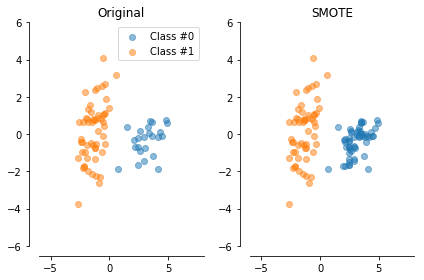

In [16]:
# generate plots
f, (ax1, ax2) = plt.subplots(1, 2)
c0, c1 = plot_resampling(ax1, X_vis, y, 'Original')
plot_resampling(ax2, X_res_vis, y_res, 'SMOTE')
ax1.legend((c0, c1), ('Class #0', 'Class #1'))
plt.tight_layout()
plt.show()

Thus, we can see that SMOTE densely populates the minority class with synthetic data.

It’s possible to combine over-sampling and under-sampling techniques into a hybrid strategy. Common examples include SMOTE and Tomek links or SMOTE and Edited Nearest Neighbors (ENN). Additional ways of learning on imbalanced datasets include weighing training instances, introducing different misclassification costs for positive and negative examples and bootstrapping.

**References**


1. H. He and E. A. Garcia, "Learning from imbalanced data", IEEE trans. on knowl. and data eng., pg. 1263-1284, 2009
2. G. Lemaitre, F. Nogueira and C. K. Aridas, "Imbalanced-learn: A Python Toolbox to Tackle the Curse of Imbalanced Datasets in Machine Learning", JMLR, 2017